In [1]:
import cv2
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import skimage
#%matplotlib inline
%pylab inline
import os
import sys
from time import time
from glob import glob
sys.path.append(os.environ['REPO_DIR'])
from extractPatches import patch_extractor
from lib.utils import configuration, run

Populating the interactive namespace from numpy and matplotlib


In [2]:
def CDF(x):
    x=np.sort(x)
    size=x.shape[0]
    y=np.arange(0,size)/size
    return x,y

In [3]:
def setup_download_from_s3(rel_fp, recursive=True):
    s3_fp = 's3://mousebrainatlas-data/' + rel_fp
    local_fp = os.environ['ROOT_DIR'] + rel_fp

    if os.path.exists(local_fp):
        print('ALREADY DOWNLOADED FILE')
        return

    if recursive:
        run('aws s3 cp --recursive {0} {1}'.format(s3_fp, local_fp))
    else:
        run('aws s3 cp {0} {1}'.format(s3_fp, local_fp))
        
def setup_upload_from_s3(rel_fp, recursive=True):
    s3_fp = 's3://mousebrainatlas-data/' + rel_fp
    local_fp = os.environ['ROOT_DIR'] + rel_fp

    if recursive:
        run('aws s3 cp --recursive {0} {1}'.format(local_fp, s3_fp))
    else:
        run('aws s3 cp {0} {1}'.format(local_fp, s3_fp))

In [4]:
def features_extractor(tile, params, extractor, threshold):
    if params['preprocessing']['polarity']==-1:
        tile = 255-tile
    min_std=params['preprocessing']['min_std']
    _std = np.std(tile.flatten())

    extracted = []
    if _std < min_std:
        extracted.append([0] * 1981)
    else:
        Stats = extractor.segment_cells(tile)
        cells = extractor.extract_blobs(Stats,tile)
        cells = pd.DataFrame(cells)
        cells = cells[cells['padded_patch'].notnull()]
        cells = cells.drop(['padded_patch','left','top'],1)
        cells = np.asarray(cells)
        for k in range(len(cells)):
            cells[k][0] = cells[k][0][:10]
        origin = np.concatenate((np.array(list(cells[:,0])),cells[:,1:]),axis=1)
        for k in range(origin.shape[1]):
            x, y = CDF(origin[:,k])
            ten = [y[np.argmin(np.absolute(x-threshold[k][j]))] for j in range(99)]
            extracted.extend(ten)
        extracted.extend([cells.shape[0]])
    return extracted

In [5]:
stack = 'MD594'
fp = os.path.join('CSHL_data_processed', stack, stack + '_sorted_filenames.txt')
setup_download_from_s3(fp, recursive=False)
with open(os.environ['ROOT_DIR']+fp, 'r') as f:
    fn_idx_tuples = [line.strip().split() for line in f.readlines()]
    section_to_filename = {int(idx): fn for fn, idx in fn_idx_tuples}

fn = 'CSHL_data_processed/MD589/ThresholdsV2.pkl'
setup_download_from_s3(fn, recursive=False)
thresholds = pickle.load(open(os.environ['ROOT_DIR']+fn,'rb'))

fname = os.path.join('CSHL_data_processed', stack, 'Annotation.npy')
setup_download_from_s3(fname, recursive=False)
annotation = np.load(os.environ['ROOT_DIR']+fname, allow_pickle = True, encoding='latin1')
contours = pd.DataFrame(annotation)
contours = contours.rename(columns={0:"name", 1:"section", 2:"vertices"})
contours_grouped = contours.groupby('section')

ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE


In [6]:
#Parameters
param = {}
param['max_depth']= 3   # depth of tree
param['eta'] = 0.2      # shrinkage parameter
param['silent'] = 1     # not silent
param['objective'] = 'binary:logistic' #'multi:softmax'
param['nthread'] = 7 # Number of threads used
param['num_class']=1
num_round = 100

In [7]:
yamlfile=os.environ['REPO_DIR']+'shape_params.yaml'
params=configuration(yamlfile).getParams()

cell_dir = os.environ['ROOT_DIR'] + 'CSHL_patch_samples_features_V2/MD589/'
cell2_dir = os.environ['ROOT_DIR'] + 'CSHL_patch_samples_features_V2/MD585/'
raw_images_root = 'CSHL_data_processed/'+stack+'/'+stack+'_prep2_lossless_gray/'
features_fn = 'CSHL_grid_features/'
if not os.path.exists(os.environ['ROOT_DIR']+features_fn):
    os.mkdir(os.environ['ROOT_DIR']+features_fn)
features_fn = features_fn+stack+'/'
if not os.path.exists(os.environ['ROOT_DIR']+features_fn):
    os.mkdir(os.environ['ROOT_DIR']+features_fn)

savepath = 'CSHL_scoremaps_new/'
if not os.path.exists(os.environ['ROOT_DIR']+savepath):
    os.mkdir(os.environ['ROOT_DIR']+savepath)
savepath = savepath+stack+'/'
if not os.path.exists(os.environ['ROOT_DIR']+savepath):
    os.mkdir(os.environ['ROOT_DIR']+savepath)

paired_structures = ['5N', '6N', '7N', '7nn', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', \
                     'SNC', 'SNR', '3N', '4N', 'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']

all_structures = paired_structures + singular_structures
window_size = 224

/Users/kuiqian/Github/shapeology_code/scripts/lib/utils.py:22: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.D=yaml.load(open(yamlFile,'r'))


In [8]:
%%time
section = 200
img_fn = raw_images_root + section_to_filename[section] + '_prep2_lossless_gray.tif'
setup_download_from_s3(img_fn, recursive=False)
img = cv2.imread(os.environ['ROOT_DIR']+img_fn, 2)
m, n = img.shape
extractor = patch_extractor(params)

ALREADY DOWNLOADED FILE
CPU times: user 834 ms, sys: 842 ms, total: 1.68 s
Wall time: 2.62 s


In [9]:
%%time
stride = 224 #int(30/0.46)
polygons = [(contour['name'], contour['vertices']) \
                for contour_id, contour in contours_grouped.get_group(section).iterrows()]
xs, ys = np.meshgrid(np.arange(0, n, stride), np.arange(0, m, stride), indexing='xy')
locations = np.c_[xs.flat, ys.flat]
valid_structure = {}
for contour_id, contour in polygons:
    valid_structure[contour_id] = contour

CPU times: user 5.41 ms, sys: 1.46 ms, total: 6.87 ms
Wall time: 7.39 ms


In [10]:
valid_structure.keys()

dict_keys(['SC', 'Pn', 'Sp5C', 'IO', 'Tz', 'VTA', 'RtTg', '7n', 'RMC', 'IC'])

In [60]:
15400*(112/65)**2

45722.508875739644

In [10]:
len(locations)

3850

In [11]:
len(grid_features)

NameError: name 'grid_features' is not defined

In [11]:
%%time
grid_features = {}
for i in range(len(locations)):
    print(i, len(locations))
    left = locations[i][0]
    right = int(min(left + window_size, n))
    up = locations[i][1]
    down = int(min(up + window_size, m))
    tile = img[up:down, left:right]
    grid_index = str(section)+'_'+str(left)+'_'+str(up)
    try:
        extracted = features_extractor(tile, params, extractor, thresholds)
        grid_features[grid_index] = extracted
    except:
        continue

0 3850
1 3850
2 3850
3 3850
4 3850
5 3850
6 3850
7 3850
8 3850
9 3850
10 3850
11 3850
12 3850
13 3850
14 3850
15 3850
16 3850
17 3850
18 3850
19 3850
20 3850
21 3850
22 3850
23 3850
24 3850
25 3850
26 3850
27 3850
28 3850
29 3850
30 3850
31 3850
32 3850
33 3850
34 3850
35 3850
36 3850
37 3850
38 3850
39 3850
40 3850
41 3850
42 3850
43 3850
44 3850
45 3850
46 3850
47 3850
48 3850
49 3850
50 3850
51 3850
52 3850
53 3850
54 3850
55 3850
56 3850
57 3850
58 3850
59 3850
60 3850
61 3850
62 3850
63 3850
64 3850
65 3850
66 3850
67 3850
68 3850
69 3850
70 3850
71 3850
72 3850
73 3850
74 3850
75 3850
76 3850
77 3850
78 3850
79 3850
80 3850
81 3850
82 3850
83 3850
84 3850
85 3850
86 3850
87 3850
88 3850
89 3850
90 3850
91 3850
92 3850
93 3850
94 3850
95 3850
96 3850
97 3850
98 3850
99 3850
100 3850
101 3850
102 3850
103 3850
104 3850
105 3850
106 3850
107 3850
108 3850
109 3850
110 3850
111 3850
112 3850
113 3850
114 3850
115 3850
116 3850
117 3850
118 3850
119 3850
120 3850
121 3850
122 3850
123

925 3850
926 3850
927 3850
928 3850
929 3850
930 3850
931 3850
932 3850
933 3850
934 3850
935 3850
936 3850
937 3850
938 3850
939 3850
940 3850
941 3850
942 3850
943 3850
944 3850
945 3850
946 3850
947 3850
948 3850
949 3850
950 3850
951 3850
952 3850
953 3850
954 3850
955 3850
956 3850
957 3850
958 3850
959 3850
960 3850
961 3850
962 3850
963 3850
964 3850
965 3850
966 3850
967 3850
968 3850
969 3850
970 3850
971 3850
972 3850
973 3850
974 3850
975 3850
976 3850
977 3850
978 3850
979 3850
980 3850
981 3850
982 3850
983 3850
984 3850
985 3850
986 3850
987 3850
988 3850
989 3850
990 3850
991 3850
992 3850
993 3850
994 3850
995 3850
996 3850
997 3850
998 3850
999 3850
1000 3850
1001 3850
1002 3850
1003 3850
1004 3850
1005 3850
1006 3850
1007 3850
1008 3850
1009 3850
1010 3850
1011 3850
1012 3850
1013 3850
1014 3850
1015 3850
1016 3850
1017 3850
1018 3850
1019 3850
1020 3850
1021 3850
1022 3850
1023 3850
1024 3850
1025 3850
1026 3850
1027 3850
1028 3850
1029 3850
1030 3850
1031 3850
1032 

1752 3850
1753 3850
1754 3850
1755 3850
1756 3850
1757 3850
1758 3850
1759 3850
1760 3850
1761 3850
1762 3850
1763 3850
1764 3850
1765 3850
1766 3850
1767 3850
1768 3850
1769 3850
1770 3850
1771 3850
1772 3850
1773 3850
1774 3850
1775 3850
1776 3850
1777 3850
1778 3850
1779 3850
1780 3850
1781 3850
1782 3850
1783 3850
1784 3850
1785 3850
1786 3850
1787 3850
1788 3850
1789 3850
1790 3850
1791 3850
1792 3850
1793 3850
1794 3850
1795 3850
1796 3850
1797 3850
1798 3850
1799 3850
1800 3850
1801 3850
1802 3850
1803 3850
1804 3850
1805 3850
1806 3850
1807 3850
1808 3850
1809 3850
1810 3850
1811 3850
1812 3850
1813 3850
1814 3850
1815 3850
1816 3850
1817 3850
1818 3850
1819 3850
1820 3850
1821 3850
1822 3850
1823 3850
1824 3850
1825 3850
1826 3850
1827 3850
1828 3850
1829 3850
1830 3850
1831 3850
1832 3850
1833 3850
1834 3850
1835 3850
1836 3850
1837 3850
1838 3850
1839 3850
1840 3850
1841 3850
1842 3850
1843 3850
1844 3850
1845 3850
1846 3850
1847 3850
1848 3850
1849 3850
1850 3850
1851 3850


2572 3850
2573 3850
2574 3850
2575 3850
2576 3850
2577 3850
2578 3850
2579 3850
2580 3850
2581 3850
2582 3850
2583 3850
2584 3850
2585 3850
2586 3850
2587 3850
2588 3850
2589 3850
2590 3850
2591 3850
2592 3850
2593 3850
2594 3850
2595 3850
2596 3850
2597 3850
2598 3850
2599 3850
2600 3850
2601 3850
2602 3850
2603 3850
2604 3850
2605 3850
2606 3850
2607 3850
2608 3850
2609 3850
2610 3850
2611 3850
2612 3850
2613 3850
2614 3850
2615 3850
2616 3850
2617 3850
2618 3850
2619 3850
2620 3850
2621 3850
2622 3850
2623 3850
2624 3850
2625 3850
2626 3850
2627 3850
2628 3850
2629 3850
2630 3850
2631 3850
2632 3850
2633 3850
2634 3850
2635 3850
2636 3850
2637 3850
2638 3850
2639 3850
2640 3850
2641 3850
2642 3850
2643 3850
2644 3850
2645 3850
2646 3850
2647 3850
2648 3850
2649 3850
2650 3850
2651 3850
2652 3850
2653 3850
2654 3850
2655 3850
2656 3850
2657 3850
2658 3850
2659 3850
2660 3850
2661 3850
2662 3850
2663 3850
2664 3850
2665 3850
2666 3850
2667 3850
2668 3850
2669 3850
2670 3850
2671 3850


3392 3850
3393 3850
3394 3850
3395 3850
3396 3850
3397 3850
3398 3850
3399 3850
3400 3850
3401 3850
3402 3850
3403 3850
3404 3850
3405 3850
3406 3850
3407 3850
3408 3850
3409 3850
3410 3850
3411 3850
3412 3850
3413 3850
3414 3850
3415 3850
3416 3850
3417 3850
3418 3850
3419 3850
3420 3850
3421 3850
3422 3850
3423 3850
3424 3850
3425 3850
3426 3850
3427 3850
3428 3850
3429 3850
3430 3850
3431 3850
3432 3850
3433 3850
3434 3850
3435 3850
3436 3850
3437 3850
3438 3850
3439 3850
3440 3850
3441 3850
3442 3850
3443 3850
3444 3850
3445 3850
3446 3850
3447 3850
3448 3850
3449 3850
3450 3850
3451 3850
3452 3850
3453 3850
3454 3850
3455 3850
3456 3850
3457 3850
3458 3850
3459 3850
3460 3850
3461 3850
3462 3850
3463 3850
3464 3850
3465 3850
3466 3850
3467 3850
3468 3850
3469 3850
3470 3850
3471 3850
3472 3850
3473 3850
3474 3850
3475 3850
3476 3850
3477 3850
3478 3850
3479 3850
3480 3850
3481 3850
3482 3850
3483 3850
3484 3850
3485 3850
3486 3850
3487 3850
3488 3850
3489 3850
3490 3850
3491 3850


In [ ]:
%%time
for structure in all_structures:
    if structure not in valid_structure.keys():
        continue
    print(structure)
    subpath = savepath + structure + '/'
    if not os.path.exists(os.environ['ROOT_DIR']+subpath):
        os.mkdir(os.environ['ROOT_DIR']+subpath)
    
    fp =[]
    fp.append(cell_dir+structure+'/MD589_'+structure+'_positive.pkl') 
    fp.append(cell_dir+structure+'/MD589_'+structure+'_negative.pkl') 
    X_train = []
    y_train = []
    for state in range(2):
        clouds = pickle.load(open(fp[state],'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1-state]*len(clouds))
    
    fp =[]
    fp.append(cell2_dir+structure+'/MD585_'+structure+'_positive.pkl') 
    fp.append(cell2_dir+structure+'/MD585_'+structure+'_negative.pkl') 
    for state in range(2):
        clouds = pickle.load(open(fp[state],'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1-state]*len(clouds))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    bst = xgb.train(param, dtrain, num_round, verbose_eval=False)

    if structure == '7nn':
        structure = '7n'
    
    scoremap = np.zeros([m,n])
    for x,y in locations:
        try:
            grid_index = str(section)+'_'+str(x)+'_'+str(y)
            feature_vector = grid_features[grid_index]
            xtest = xgb.DMatrix(feature_vector)
            score = bst.predict(xtest, output_margin=True, ntree_limit=bst.best_ntree_limit)
            origin = scoremap[y:y+window_size, x:x+window_size]
            comp = np.absolute(origin) - np.absolute(score)
            scoremap[y:y+window_size, x:x+window_size] = origin * (comp > 0) + score * (comp < 0)
        except:
            continue
    scoremap = 1 / (1+np.exp(-scoremap))
#     scoremap = (scoremap - scoremap.min()) / (scoremap.max() - scoremap.min())
    gray = scoremap * 255
    gray = gray.astype(np.uint8)
    if structure in valid_structure.keys():
        polygon = valid_structure[structure]
        rgb = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)
        com = cv2.polylines(rgb.copy(), [polygon.astype(np.int32)], True, [0, 255, 0], 15, lineType=8)
        polygon = polygon.copy()/32
        com32 = cv2.polylines(rgb[::32,::32,:].copy(), [polygon.astype(np.int32)], True, [0, 255, 0], 2, lineType=8)
    else:
        com = gray
        com32 = com[::32,::32]
    filename = subpath + structure + '_' + str(section) + '.tif'
    cv2.imwrite(os.environ['ROOT_DIR']+filename, com)
    filename = subpath + structure + '_' + str(section) + '_32.tif'
    cv2.imwrite(os.environ['ROOT_DIR']+filename, com32)

Pn
Tz
RMC


In [1]:
a = np.array([[0, 1], [1, 0]])
1/(1+np.exp(-a))

NameError: name 'np' is not defined

True

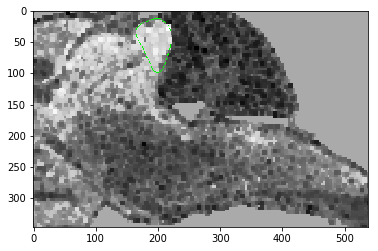

In [55]:
# figure(figsize=[8,8])
com = cv2.polylines(rgb.copy(), [polygon.astype(np.int32)], True, [0, 255, 0], 30, lineType=8)
imshow(com[::32,::32])
cv2.imwrite(os.environ['ROOT_DIR']+filename, com[::32,::32])

In [56]:
len(grid_features.keys())

15354